In [2]:
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt
import seaborn.objects as so
import seaborn as sns
import numpy as np

### Testing the number of GPU

In [3]:
print(f"Number of GPU: { len( tf.config.list_physical_devices('GPU'))}")

Number of GPU: 2


### Reading the DATA

In [4]:
w_dir = pathlib.Path('/home/antirrabia/Documents/DeepLearnin/DATASETS/CatsVsDogs/cats_vs_dogs_small/')

In [6]:
tr_d = image_dataset_from_directory(
    w_dir / 'train',
    image_size=(180,180),
    batch_size=32
)

va_d = image_dataset_from_directory(
    w_dir / 'validation',
    image_size=(180,180),
    batch_size=32
)

te_d = image_dataset_from_directory(
    w_dir / 'test',
    image_size=(180,180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### importing and freezing VGG16

In [7]:
conv_base = keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet'
)

# Freezing
conv_base.trainable = False

### Augmentation

In [8]:
data_augmentation = keras.Sequential( 
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

### Model

In [11]:
inputs = keras.Input(shape=(180,180,3))

x = data_augmentation(inputs)

x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)

# our Classifier
x = layers.Flatten()(x)

x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### Training

In [13]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath='CatsVsDogsPreTrainedWithAugmentation.keras',
        monitor='val_loss',
        save_best_only=True
    )
]

history = model.fit(
    tr_d,
    epochs=52,
    validation_data=va_d,
    callbacks=callbacks
)

Epoch 1/52


2023-04-07 11:41:01.043422: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-04-07 11:41:01.277632: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-07 11:41:01.278630: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-07 11:41:01.278652: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-07 11:41:01.279493: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-07 11:41:01.279535: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-07 11:41:01.664675: W tensorflow/core/common_runtime/bf

62/63 [============================>.] - ETA: 0s - loss: 18.8674 - accuracy: 0.8977

2023-04-07 11:41:19.987339: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


63/63 [==============================] - 29s 352ms/step - loss: 18.7567 - accuracy: 0.8980 - val_loss: 24.4292 - val_accuracy: 0.8950
Epoch 2/52
63/63 [==============================] - 18s 284ms/step - loss: 6.1763 - accuracy: 0.9570 - val_loss: 4.2478 - val_accuracy: 0.9740
Epoch 3/52
63/63 [==============================] - 18s 283ms/step - loss: 5.8117 - accuracy: 0.9560 - val_loss: 4.9150 - val_accuracy: 0.9730
Epoch 4/52
63/63 [==============================] - 18s 280ms/step - loss: 4.2478 - accuracy: 0.9645 - val_loss: 5.8286 - val_accuracy: 0.9700
Epoch 5/52
63/63 [==============================] - 18s 280ms/step - loss: 4.6815 - accuracy: 0.9630 - val_loss: 16.7241 - val_accuracy: 0.9350
Epoch 6/52
63/63 [==============================] - 18s 281ms/step - loss: 3.4522 - accuracy: 0.9705 - val_loss: 7.1145 - val_accuracy: 0.9710
Epoch 7/52
63/63 [==============================] - 18s 282ms/step - loss: 2.9122 - accuracy: 0.9760 - val_loss: 5.3955 - val_accuracy: 0.9760
Epoch 8

### Seeing the training

Text(0.5, 1.0, 'Training and Validation Loss')

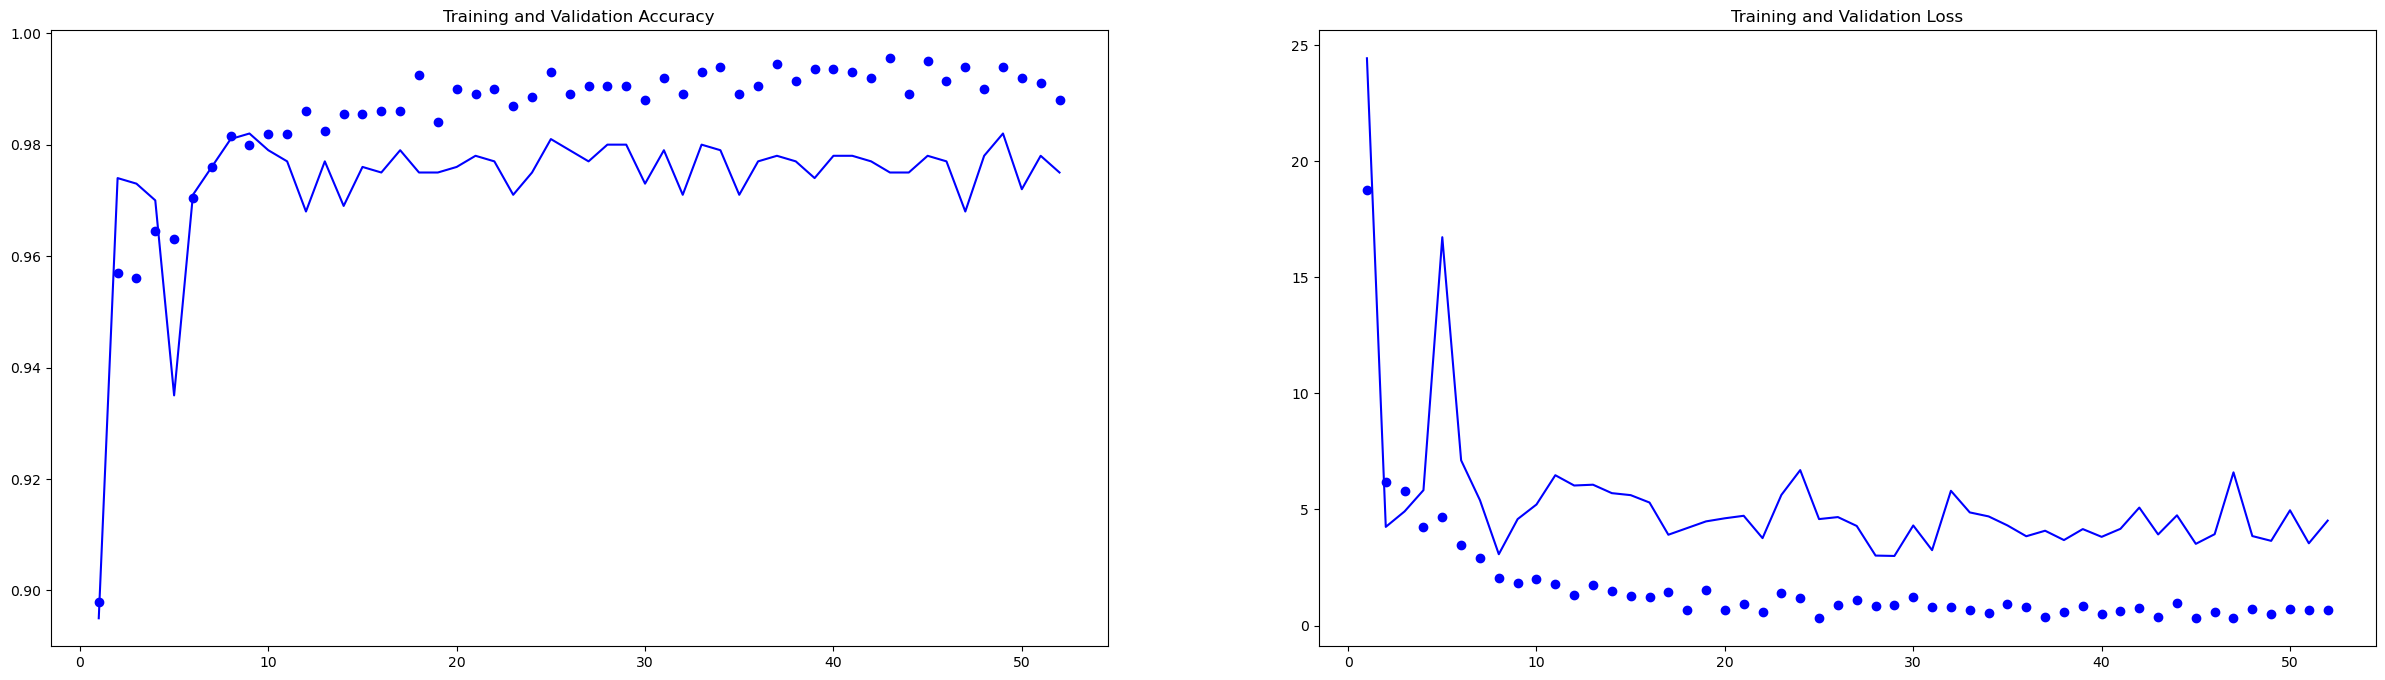

In [18]:
# Accuracy
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30,8))

ax[0].plot(epochs, accuracy, 'ob', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'b', label='Validation Accuracy')
ax[0].set_title('Training and Validation Accuracy')

ax[1].plot(epochs, loss, 'bo', label='Training Loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
ax[1].set_title('Training and Validation Loss')

